# LGBM - Training

Sources
1. [LGBM & Deberta Explained by ZULQARNAIN ALI](https://www.kaggle.com/code/zulqarnainalipk/lgbm-deberta-explained)

## Setup

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
os.chdir("../../")

In [3]:
from lib.config import config
from lib.paths import Paths
from lib.utils.utils import seed_everything
from lib.model.utils import get_score

In [4]:
seed_everything()

## Model Training

### Dataset Creation

In [5]:
df = pd.read_csv(Paths.FEATURE_ENGG_CSV_PATH)
df.shape

(17300, 21867)

In [6]:
X, y = df.drop(columns=["score", "essay_id"]), df.loc[:, "score"]
del df

X.shape, y.shape

((17300, 21865), (17300,))

In [7]:
X, y = X.to_numpy(), y.to_numpy()

### Callbacks

In [8]:
from lightgbm import log_evaluation, early_stopping

In [9]:
callbacks = [
    log_evaluation(period=25),
    early_stopping(stopping_rounds=75, first_metric_only=True),
]

### Scoring Functions

In [10]:
from sklearn.metrics import cohen_kappa_score

In [11]:
a = config.lgbm_a
b = config.lgbm_b

In [12]:
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return "QWK", qwk, True


def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1 / 2 * np.sum((preds - labels) ** 2)
    g = 1 / 2 * np.sum((preds - a) ** 2 + b)
    df = preds - labels
    dg = preds - a
    grad = (df / g - f * dg / g**2) * len(labels)
    hess = np.ones(len(labels))
    return grad, hess

### Training Loop

In [13]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

In [14]:
def train_loop(X_train, y_train, X_valid, y_valid):
    y_valid_int = y_valid.astype(np.int64)
    y_train = y_train.astype(np.float32) - a
    y_valid = y_valid.astype(np.float32) - a

    model = lgb.LGBMRegressor(
        objective=qwk_obj,
        metrics="None",
        learning_rate=0.01,
        max_depth=5,
        num_leaves=10,
        colsample_bytree=0.3,
        reg_alpha=0.7,
        reg_lambda=0.1,
        n_estimators=700,
        random_state=config.random_seed,
        extra_trees=True,
        class_weight="balanced",
        n_jobs=6,
        verbosity=0,
    )

    # Train model
    predictor = model.fit(
        X_train,
        y_train,
        eval_names=["train", "valid"],
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_metric=quadratic_weighted_kappa,
        callbacks=callbacks,
    )

    # Validate model
    preds = predictor.predict(X_valid)
    preds = preds + a
    preds = preds.clip(1, 6).round()
    f1 = f1_score(y_valid_int, preds, average="weighted")
    qwk = cohen_kappa_score(y_valid_int, preds, weights="quadratic")

    print(f"F1 Score: {f1:<8.7f}\t\tQWK Score: {qwk:>8.7f}")

    cm = confusion_matrix(y_valid_int, preds, labels=list(range(1, 7)))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1, 7)))
    disp.plot()
    plt.show()

    return predictor

### Fold Loop

In [15]:
from sklearn.model_selection import StratifiedKFold
import pickle as pkl

In [16]:
skf = StratifiedKFold(
    n_splits=config.lgbm_n_folds,
    random_state=config.random_seed,
    shuffle=True,
)

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.122616	valid's QWK: 0.116222
[50]	train's QWK: 0.621733	valid's QWK: 0.613404
[75]	train's QWK: 0.681242	valid's QWK: 0.688096
[100]	train's QWK: 0.704584	valid's QWK: 0.700598
[125]	train's QWK: 0.731512	valid's QWK: 0.719425
[150]	train's QWK: 0.744281	valid's QWK: 0.732095
[175]	train's QWK: 0.75381	valid's QWK: 0.735292
[200]	train's QWK: 0.762129	valid's QWK: 0.7464
[225]	train's QWK: 0.769556	valid's QWK: 0.749793
[250]	train's QWK: 0.7762	valid's QWK: 0.753138
[275]	train's QWK: 0.782592	valid's QWK: 0.752684
[300]	train's QWK: 0.787767	valid's QWK: 0.756647
[325]	train's QWK: 0.790531	valid's QWK: 0.760439
[350]	train's QWK: 0.793886	valid's QWK: 0.766143
[375]	train's QWK: 0.79602	valid's QWK: 0.766706
[400]	train's QWK: 0.798858	valid's QWK: 0.770311
[425]	train's QWK: 0.801593	valid's QWK: 0.774623
[450]	train's QWK: 0.803329	valid's QWK: 0

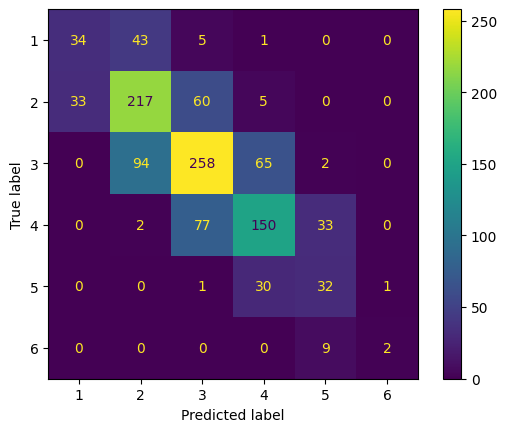

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.117413	valid's QWK: 0.117566
[50]	train's QWK: 0.621797	valid's QWK: 0.640857
[75]	train's QWK: 0.682104	valid's QWK: 0.701693
[100]	train's QWK: 0.709241	valid's QWK: 0.719969
[125]	train's QWK: 0.733	valid's QWK: 0.742285
[150]	train's QWK: 0.744396	valid's QWK: 0.756655
[175]	train's QWK: 0.753497	valid's QWK: 0.764042
[200]	train's QWK: 0.761266	valid's QWK: 0.770664
[225]	train's QWK: 0.768479	valid's QWK: 0.775291
[250]	train's QWK: 0.7742	valid's QWK: 0.779241
[275]	train's QWK: 0.77966	valid's QWK: 0.786364
[300]	train's QWK: 0.783873	valid's QWK: 0.789819
[325]	train's QWK: 0.787425	valid's QWK: 0.79416
[350]	train's QWK: 0.790907	valid's QWK: 0.795021
[375]	train's QWK: 0.793692	valid's QWK: 0.796169
[400]	train's QWK: 0.796368	valid's QWK: 0.797443
[425]	train's QWK: 0.799386	valid's QWK: 0.798103
[450]	train's QWK: 0.801104	valid's QWK: 0.

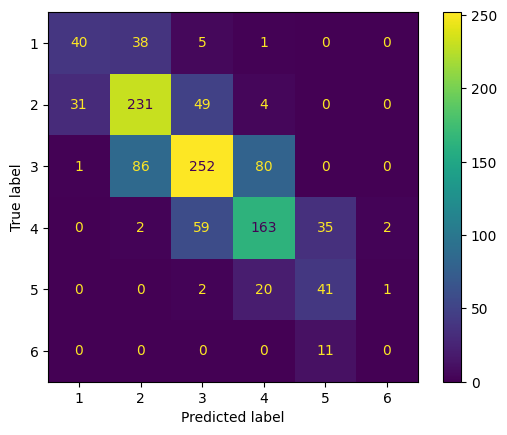

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.104425	valid's QWK: 0.128326
[50]	train's QWK: 0.620867	valid's QWK: 0.644709
[75]	train's QWK: 0.683085	valid's QWK: 0.697498
[100]	train's QWK: 0.70487	valid's QWK: 0.718986
[125]	train's QWK: 0.72951	valid's QWK: 0.748657
[150]	train's QWK: 0.745131	valid's QWK: 0.758787
[175]	train's QWK: 0.753648	valid's QWK: 0.767341
[200]	train's QWK: 0.760911	valid's QWK: 0.776619
[225]	train's QWK: 0.768653	valid's QWK: 0.783163
[250]	train's QWK: 0.775396	valid's QWK: 0.789495
[275]	train's QWK: 0.78037	valid's QWK: 0.795818
[300]	train's QWK: 0.785558	valid's QWK: 0.799775
[325]	train's QWK: 0.788841	valid's QWK: 0.800594
[350]	train's QWK: 0.791969	valid's QWK: 0.803888
[375]	train's QWK: 0.794516	valid's QWK: 0.806056
[400]	train's QWK: 0.796972	valid's QWK: 0.80682
[425]	train's QWK: 0.799988	valid's QWK: 0.811038
[450]	train's QWK: 0.802525	valid's QWK:

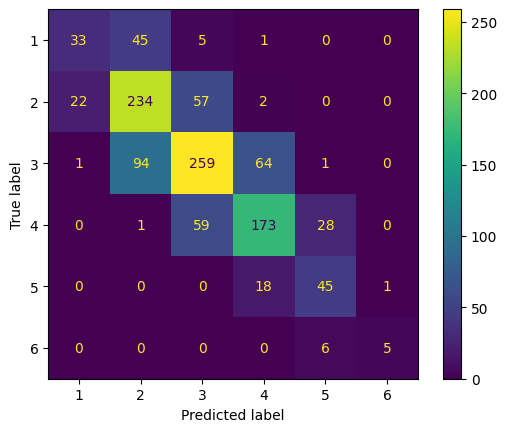

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.105183	valid's QWK: 0.108524
[50]	train's QWK: 0.616679	valid's QWK: 0.619595
[75]	train's QWK: 0.681692	valid's QWK: 0.687888
[100]	train's QWK: 0.705336	valid's QWK: 0.714267
[125]	train's QWK: 0.730289	valid's QWK: 0.7325
[150]	train's QWK: 0.744215	valid's QWK: 0.752771
[175]	train's QWK: 0.753386	valid's QWK: 0.762182
[200]	train's QWK: 0.761181	valid's QWK: 0.765575
[225]	train's QWK: 0.770075	valid's QWK: 0.774352
[250]	train's QWK: 0.776305	valid's QWK: 0.77725
[275]	train's QWK: 0.781294	valid's QWK: 0.790143
[300]	train's QWK: 0.785652	valid's QWK: 0.793498
[325]	train's QWK: 0.788875	valid's QWK: 0.795428
[350]	train's QWK: 0.791786	valid's QWK: 0.796956
[375]	train's QWK: 0.794445	valid's QWK: 0.79916
[400]	train's QWK: 0.797485	valid's QWK: 0.800844
[425]	train's QWK: 0.800179	valid's QWK: 0.799804
[450]	train's QWK: 0.802443	valid's QWK:

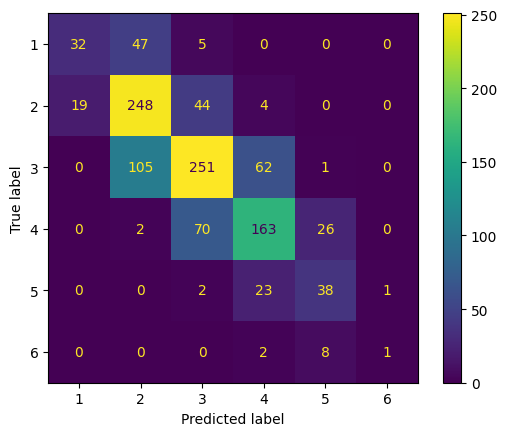

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.121318	valid's QWK: 0.108328
[50]	train's QWK: 0.621835	valid's QWK: 0.616753
[75]	train's QWK: 0.685648	valid's QWK: 0.668725
[100]	train's QWK: 0.706593	valid's QWK: 0.702264
[125]	train's QWK: 0.729831	valid's QWK: 0.726454
[150]	train's QWK: 0.74358	valid's QWK: 0.742288
[175]	train's QWK: 0.752479	valid's QWK: 0.750812
[200]	train's QWK: 0.759822	valid's QWK: 0.754957
[225]	train's QWK: 0.767853	valid's QWK: 0.760393
[250]	train's QWK: 0.775289	valid's QWK: 0.763648
[275]	train's QWK: 0.78134	valid's QWK: 0.770489
[300]	train's QWK: 0.785913	valid's QWK: 0.772387
[325]	train's QWK: 0.789662	valid's QWK: 0.775798
[350]	train's QWK: 0.792898	valid's QWK: 0.778374
[375]	train's QWK: 0.794995	valid's QWK: 0.780789
[400]	train's QWK: 0.797593	valid's QWK: 0.78223
[425]	train's QWK: 0.800085	valid's QWK: 0.785113
[450]	train's QWK: 0.802198	valid's QWK

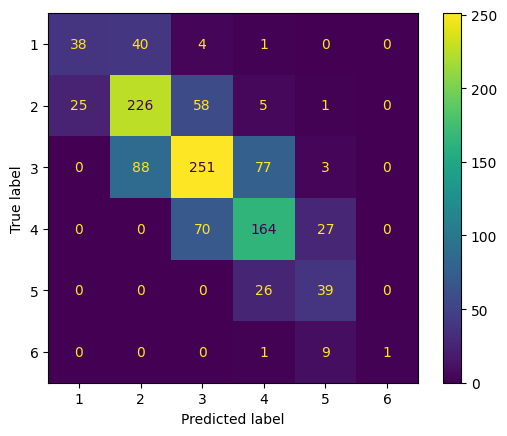

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.137894	valid's QWK: 0.143912
[50]	train's QWK: 0.625841	valid's QWK: 0.609664
[75]	train's QWK: 0.684993	valid's QWK: 0.670046
[100]	train's QWK: 0.708834	valid's QWK: 0.688036
[125]	train's QWK: 0.731978	valid's QWK: 0.709834
[150]	train's QWK: 0.745806	valid's QWK: 0.716851
[175]	train's QWK: 0.755679	valid's QWK: 0.729758
[200]	train's QWK: 0.763116	valid's QWK: 0.743686
[225]	train's QWK: 0.770973	valid's QWK: 0.750015
[250]	train's QWK: 0.776415	valid's QWK: 0.75411
[275]	train's QWK: 0.781519	valid's QWK: 0.761331
[300]	train's QWK: 0.785479	valid's QWK: 0.768739
[325]	train's QWK: 0.789339	valid's QWK: 0.770439
[350]	train's QWK: 0.793223	valid's QWK: 0.778508
[375]	train's QWK: 0.796961	valid's QWK: 0.778618
[400]	train's QWK: 0.799031	valid's QWK: 0.780279
[425]	train's QWK: 0.800743	valid's QWK: 0.781891
[450]	train's QWK: 0.80264	valid's QW

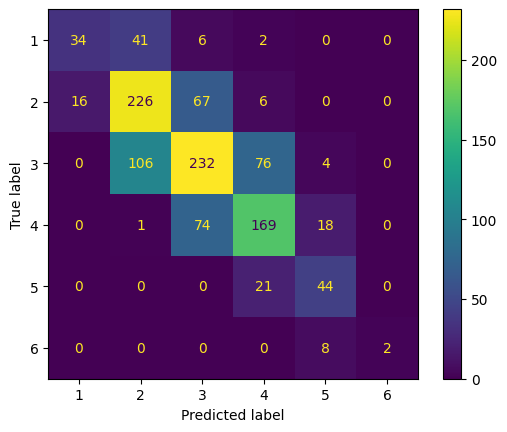

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.147509	valid's QWK: 0.119719
[50]	train's QWK: 0.612481	valid's QWK: 0.611584
[75]	train's QWK: 0.678304	valid's QWK: 0.673707
[100]	train's QWK: 0.709835	valid's QWK: 0.699243
[125]	train's QWK: 0.733088	valid's QWK: 0.720749
[150]	train's QWK: 0.744445	valid's QWK: 0.733381
[175]	train's QWK: 0.752736	valid's QWK: 0.737803
[200]	train's QWK: 0.760896	valid's QWK: 0.742777
[225]	train's QWK: 0.769744	valid's QWK: 0.752407
[250]	train's QWK: 0.777316	valid's QWK: 0.757826
[275]	train's QWK: 0.782374	valid's QWK: 0.766281
[300]	train's QWK: 0.78699	valid's QWK: 0.766629
[325]	train's QWK: 0.790786	valid's QWK: 0.770436
[350]	train's QWK: 0.793722	valid's QWK: 0.770244
[375]	train's QWK: 0.795558	valid's QWK: 0.776966
[400]	train's QWK: 0.798731	valid's QWK: 0.778638
[425]	train's QWK: 0.801242	valid's QWK: 0.779208
[450]	train's QWK: 0.803388	valid's Q

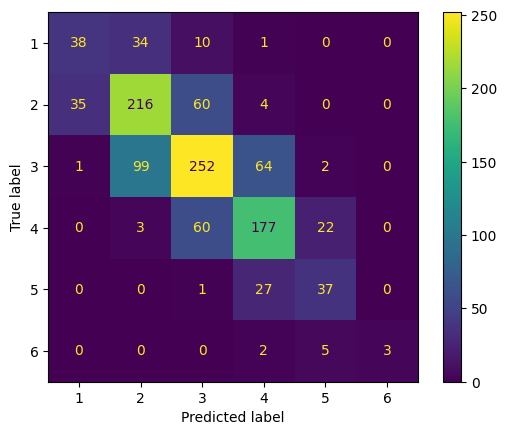

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.135484	valid's QWK: 0.125926
[50]	train's QWK: 0.619172	valid's QWK: 0.613422
[75]	train's QWK: 0.676165	valid's QWK: 0.67768
[100]	train's QWK: 0.705926	valid's QWK: 0.713212
[125]	train's QWK: 0.730735	valid's QWK: 0.722364
[150]	train's QWK: 0.743746	valid's QWK: 0.732905
[175]	train's QWK: 0.754191	valid's QWK: 0.740754
[200]	train's QWK: 0.761469	valid's QWK: 0.745306
[225]	train's QWK: 0.770584	valid's QWK: 0.750704
[250]	train's QWK: 0.775908	valid's QWK: 0.75879
[275]	train's QWK: 0.781468	valid's QWK: 0.767437
[300]	train's QWK: 0.786532	valid's QWK: 0.772294
[325]	train's QWK: 0.789754	valid's QWK: 0.77544
[350]	train's QWK: 0.793521	valid's QWK: 0.775802
[375]	train's QWK: 0.796518	valid's QWK: 0.777752
[400]	train's QWK: 0.798909	valid's QWK: 0.77779
[425]	train's QWK: 0.800742	valid's QWK: 0.780953
[450]	train's QWK: 0.802368	valid's QWK:

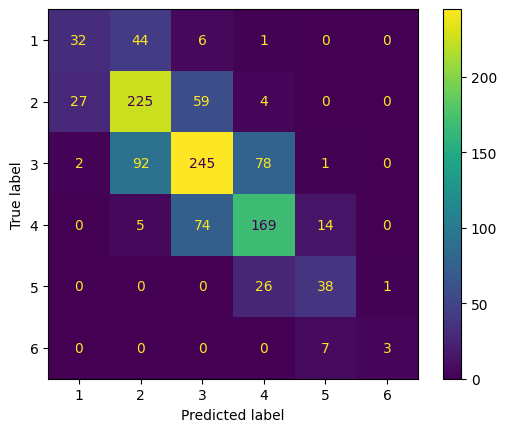

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.135451	valid's QWK: 0.121298
[50]	train's QWK: 0.617705	valid's QWK: 0.62809
[75]	train's QWK: 0.678562	valid's QWK: 0.686436
[100]	train's QWK: 0.705033	valid's QWK: 0.711516
[125]	train's QWK: 0.731186	valid's QWK: 0.734246
[150]	train's QWK: 0.744042	valid's QWK: 0.750867
[175]	train's QWK: 0.751445	valid's QWK: 0.756776
[200]	train's QWK: 0.760712	valid's QWK: 0.760614
[225]	train's QWK: 0.768027	valid's QWK: 0.764923
[250]	train's QWK: 0.77548	valid's QWK: 0.77681
[275]	train's QWK: 0.780587	valid's QWK: 0.78734
[300]	train's QWK: 0.784865	valid's QWK: 0.791077
[325]	train's QWK: 0.789145	valid's QWK: 0.794747
[350]	train's QWK: 0.791815	valid's QWK: 0.797293
[375]	train's QWK: 0.794547	valid's QWK: 0.798328
[400]	train's QWK: 0.797352	valid's QWK: 0.797105
[425]	train's QWK: 0.799256	valid's QWK: 0.797993
Early stopping, best iteration is:
[371]

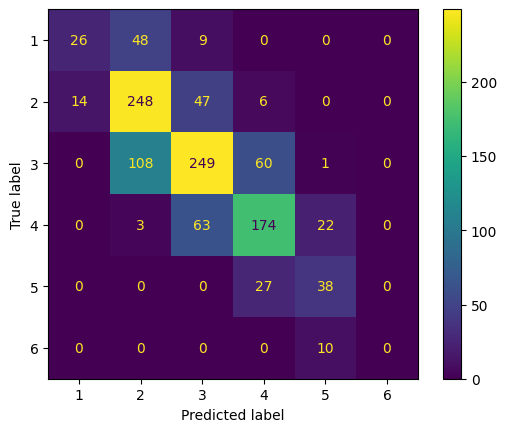

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.130034	valid's QWK: 0.133258
[50]	train's QWK: 0.622534	valid's QWK: 0.618868
[75]	train's QWK: 0.684809	valid's QWK: 0.674079
[100]	train's QWK: 0.711856	valid's QWK: 0.701602
[125]	train's QWK: 0.733875	valid's QWK: 0.724254
[150]	train's QWK: 0.74515	valid's QWK: 0.735985
[175]	train's QWK: 0.754723	valid's QWK: 0.74235
[200]	train's QWK: 0.763612	valid's QWK: 0.74881
[225]	train's QWK: 0.770867	valid's QWK: 0.754239
[250]	train's QWK: 0.777424	valid's QWK: 0.761898
[275]	train's QWK: 0.78243	valid's QWK: 0.766816
[300]	train's QWK: 0.786902	valid's QWK: 0.773092
[325]	train's QWK: 0.790222	valid's QWK: 0.775989
[350]	train's QWK: 0.793655	valid's QWK: 0.780237
[375]	train's QWK: 0.796713	valid's QWK: 0.782867
[400]	train's QWK: 0.799371	valid's QWK: 0.790371
[425]	train's QWK: 0.80129	valid's QWK: 0.788931
[450]	train's QWK: 0.803654	valid's QWK: 

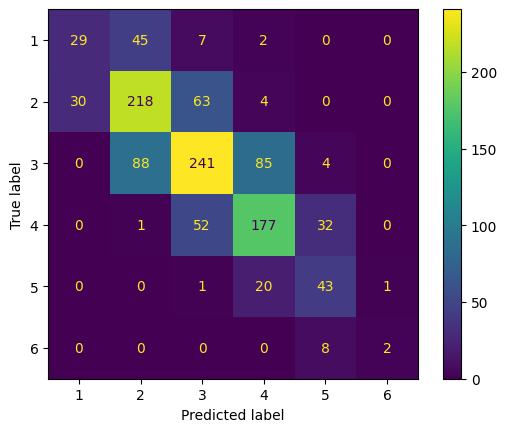

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.138367	valid's QWK: 0.131933
[50]	train's QWK: 0.613038	valid's QWK: 0.598235
[75]	train's QWK: 0.678382	valid's QWK: 0.682002
[100]	train's QWK: 0.704926	valid's QWK: 0.702529
[125]	train's QWK: 0.730295	valid's QWK: 0.726034
[150]	train's QWK: 0.743623	valid's QWK: 0.739016
[175]	train's QWK: 0.751486	valid's QWK: 0.758348
[200]	train's QWK: 0.759534	valid's QWK: 0.763453
[225]	train's QWK: 0.767208	valid's QWK: 0.766984
[250]	train's QWK: 0.775202	valid's QWK: 0.773345
[275]	train's QWK: 0.780691	valid's QWK: 0.778078
[300]	train's QWK: 0.784992	valid's QWK: 0.782831
[325]	train's QWK: 0.787883	valid's QWK: 0.788009
[350]	train's QWK: 0.790444	valid's QWK: 0.791018
[375]	train's QWK: 0.792703	valid's QWK: 0.793958
[400]	train's QWK: 0.795163	valid's QWK: 0.796998
[425]	train's QWK: 0.798168	valid's QWK: 0.799849
[450]	train's QWK: 0.800469	valid's 

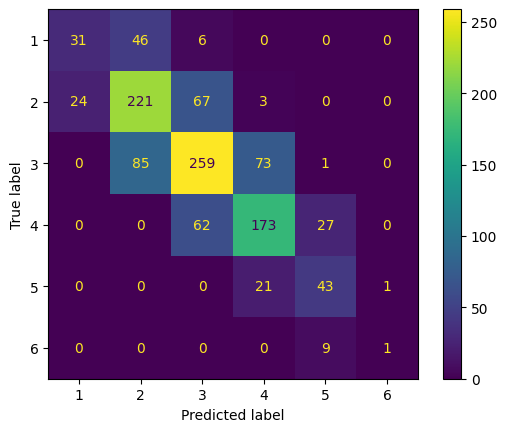

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.133438	valid's QWK: 0.162007
[50]	train's QWK: 0.627759	valid's QWK: 0.619369
[75]	train's QWK: 0.683134	valid's QWK: 0.692442
[100]	train's QWK: 0.705205	valid's QWK: 0.717497
[125]	train's QWK: 0.730514	valid's QWK: 0.744994
[150]	train's QWK: 0.743735	valid's QWK: 0.755683
[175]	train's QWK: 0.754104	valid's QWK: 0.762267
[200]	train's QWK: 0.760175	valid's QWK: 0.770769
[225]	train's QWK: 0.768253	valid's QWK: 0.773412
[250]	train's QWK: 0.774663	valid's QWK: 0.776938
[275]	train's QWK: 0.780241	valid's QWK: 0.782897
[300]	train's QWK: 0.784987	valid's QWK: 0.789319
[325]	train's QWK: 0.789335	valid's QWK: 0.790697
[350]	train's QWK: 0.792929	valid's QWK: 0.792539
[375]	train's QWK: 0.795824	valid's QWK: 0.792546
[400]	train's QWK: 0.797717	valid's QWK: 0.794071
[425]	train's QWK: 0.800266	valid's QWK: 0.798074
[450]	train's QWK: 0.802081	valid's 

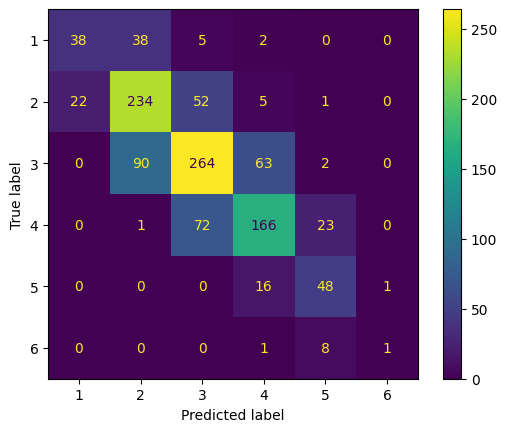

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.124621	valid's QWK: 0.122798
[50]	train's QWK: 0.621245	valid's QWK: 0.61103
[75]	train's QWK: 0.681038	valid's QWK: 0.671407
[100]	train's QWK: 0.709441	valid's QWK: 0.692165
[125]	train's QWK: 0.73265	valid's QWK: 0.722052
[150]	train's QWK: 0.744654	valid's QWK: 0.733324
[175]	train's QWK: 0.753868	valid's QWK: 0.74094
[200]	train's QWK: 0.761558	valid's QWK: 0.751224
[225]	train's QWK: 0.768922	valid's QWK: 0.762392
[250]	train's QWK: 0.774942	valid's QWK: 0.76431
[275]	train's QWK: 0.781114	valid's QWK: 0.768906
[300]	train's QWK: 0.785381	valid's QWK: 0.774253
[325]	train's QWK: 0.789088	valid's QWK: 0.782836
[350]	train's QWK: 0.7923	valid's QWK: 0.783118
[375]	train's QWK: 0.795009	valid's QWK: 0.784705
[400]	train's QWK: 0.797985	valid's QWK: 0.788163
[425]	train's QWK: 0.800337	valid's QWK: 0.790933
[450]	train's QWK: 0.802773	valid's QWK: 0

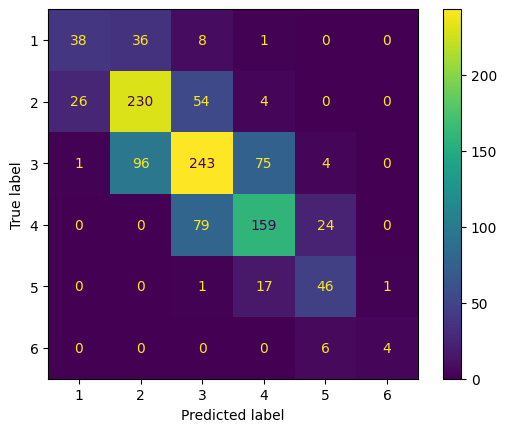

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.121698	valid's QWK: 0.104527
[50]	train's QWK: 0.621018	valid's QWK: 0.608981
[75]	train's QWK: 0.683689	valid's QWK: 0.670902
[100]	train's QWK: 0.7089	valid's QWK: 0.695234
[125]	train's QWK: 0.734113	valid's QWK: 0.720564
[150]	train's QWK: 0.744789	valid's QWK: 0.731004
[175]	train's QWK: 0.752555	valid's QWK: 0.739864
[200]	train's QWK: 0.760781	valid's QWK: 0.749766
[225]	train's QWK: 0.768199	valid's QWK: 0.762995
[250]	train's QWK: 0.774929	valid's QWK: 0.761974
[275]	train's QWK: 0.780805	valid's QWK: 0.770131
[300]	train's QWK: 0.784923	valid's QWK: 0.773135
[325]	train's QWK: 0.789522	valid's QWK: 0.779467
[350]	train's QWK: 0.792271	valid's QWK: 0.778683
[375]	train's QWK: 0.795471	valid's QWK: 0.782308
[400]	train's QWK: 0.798643	valid's QWK: 0.781759
[425]	train's QWK: 0.800674	valid's QWK: 0.788553
[450]	train's QWK: 0.802701	valid's QW

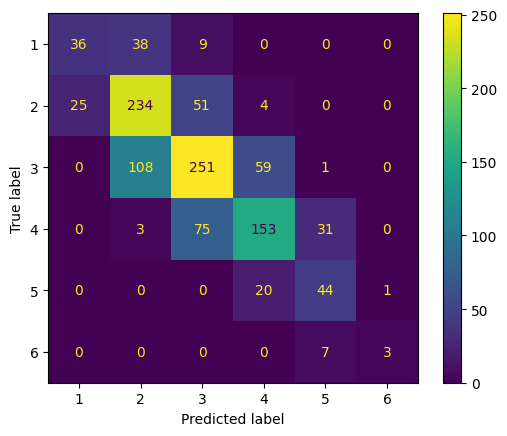

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.131562	valid's QWK: 0.137371
[50]	train's QWK: 0.613857	valid's QWK: 0.616091
[75]	train's QWK: 0.681645	valid's QWK: 0.667003
[100]	train's QWK: 0.71124	valid's QWK: 0.685987
[125]	train's QWK: 0.734499	valid's QWK: 0.722775
[150]	train's QWK: 0.74606	valid's QWK: 0.73003
[175]	train's QWK: 0.754144	valid's QWK: 0.735016
[200]	train's QWK: 0.760752	valid's QWK: 0.747132
[225]	train's QWK: 0.767335	valid's QWK: 0.755198
[250]	train's QWK: 0.774951	valid's QWK: 0.764034
[275]	train's QWK: 0.78067	valid's QWK: 0.770587
[300]	train's QWK: 0.784128	valid's QWK: 0.777542
[325]	train's QWK: 0.788805	valid's QWK: 0.778908
[350]	train's QWK: 0.791724	valid's QWK: 0.783475
[375]	train's QWK: 0.795166	valid's QWK: 0.787283
[400]	train's QWK: 0.797565	valid's QWK: 0.787495
[425]	train's QWK: 0.799666	valid's QWK: 0.789797
[450]	train's QWK: 0.801199	valid's QWK:

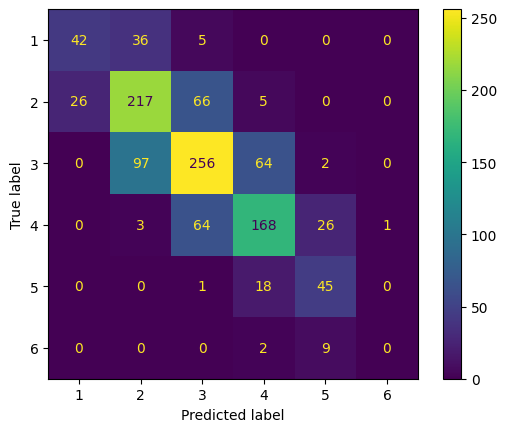

In [17]:
for idx, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    predictor = train_loop(X_train, y_train, X_valid, y_valid)

    with open(f"output/LGBM/{idx}.pkl", "wb") as file:
        pkl.dump(predictor, file)